In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import pandas as pd
from westgate.flaml_model import *
import pandas as pd
from westgate.combochart import combo_chart
from colored import Fore, Back, Style
from sklearn.ensemble._stacking import StackingClassifier

In [3]:
accepted_df = pd.read_csv('../data/AttributesLoans2022.csv', encoding='latin')
refused_raw_df = pd.read_csv('../data/refusal2022.csv', encoding='latin')

C:\Users\karim\AppData\Local\Temp\ipykernel_22956\3967161521.py:1: DtypeWarning: Columns (741) have mixed types. Specify dtype option on import or set low_memory=False.
  accepted_df = pd.read_csv('../data/AttributesLoans2022.csv', encoding='latin')


In [4]:
refused_raw_df['recurring_deposits_90_days'] = (
    refused_raw_df['recurring_deposits_current_month'] + 
    refused_raw_df['recurring_deposits_previous_month'] +
    refused_raw_df['recurring_deposits_2_months_ago']
)

refused_raw_df['sum_micro_loans_60_days'] = (
    refused_raw_df['sum_micro_loan_payments_current_month'] + 
    refused_raw_df['sum_micro_loan_payments_previous_month'] 
)

refused_raw_df['recurring_deposits_90_days'] = (
    refused_raw_df['recurring_deposits_current_month'] + 
    refused_raw_df['recurring_deposits_previous_month'] +
    refused_raw_df['recurring_deposits_2_months_ago']
)

refused_raw_df['sum_micro_loans_60_days'] = (
    refused_raw_df['sum_micro_loan_payments_current_month'] + 
    refused_raw_df['sum_micro_loan_payments_previous_month'] 
)

In [5]:
print('# loans before auto-refusal: ' + str(len(refused_raw_df)))

refused_df = refused_raw_df[refused_raw_df['account_age_days'] >= 85]

refused_df = refused_df[refused_df['count_nsf_90_days'] <= 8]

refused_df = refused_df[refused_df['count_nsf_30_days'] <= 6]

refused_df = refused_df[refused_df['count_stop_payment_90_days'] <= 4]

#refused_df = refused_df[refused_df['recurring_deposits_90_days']/3.0 >= 1800] <-- filers way too much

#refused_df = refused_df[refused_df['sum_micro_loans_60_days'] <= 1000]

print('# loans after auto-refusal: ' + str(len(refused_df)))

# loans before auto-refusal: 37398
# loans after auto-refusal: 28579


In [6]:
len(accepted_df)

10098

In [23]:
default_model = load_model(experiment_id='default_1.0', basefolder='../default_model/')

In [24]:
refusal_model = load_model(experiment_id='refusal_0.2', basefolder='../refusal_model/')

In [11]:
accepted_filtered_df = default_model.filter_df(accepted_df)

Rows with 'account_age_days' column not positive will be discarded.


In [12]:
len(accepted_filtered_df)

9507

In [13]:
accepted_filtered_df['refusal'] = 0
refused_df['refusal'] = 1

df = pd.concat([accepted_filtered_df, refused_df])

In [14]:
df['refusal'].value_counts(normalize=True)

refusal
1    0.750381
0    0.249619
Name: proportion, dtype: float64

In [16]:
 df_eng = refusal_model.feature_engineer(df)

Error calculating age with dob ########## and request_date 2022-06-15 00:00:00
Unknown string format: ##########
Error calculating age with dob ########## and request_date 2022-09-14 00:00:00
Unknown string format: ##########
Error calculating age with dob ########## and request_date 2022-10-03 00:00:00
Unknown string format: ##########
Error calculating age with dob ########## and request_date 2022-10-06 00:00:00
Unknown string format: ##########


In [17]:
filter = ~df_eng['age'].isna()
df_eng = df_eng.loc[filter]

In [18]:
len(df_eng)

38082

In [19]:
df.isna().sum().sum()

389686

In [27]:
y_proba_refusal = refusal_model.predict_proba(df, filter=False, engineer=False)

In [36]:
y_proba_refusal

,pred_proba
0,0.466438
1,0.455950
2,0.394209
3,0.677970
5,0.816133
...,...
37391,0.969733
37392,0.564390
37395,0.788355
37396,0.920893


In [28]:
y_proba_default = default_model.predict_proba(df, filter=False, engineer=False)

In [35]:
y_proba_default

,pred_proba
0,0.308119
1,0.280190
2,0.320770
3,0.150199
5,0.550394
...,...
37391,0.366666
37392,0.222906
37395,0.435246
37396,0.606285


<Axes: ylabel='Frequency'>

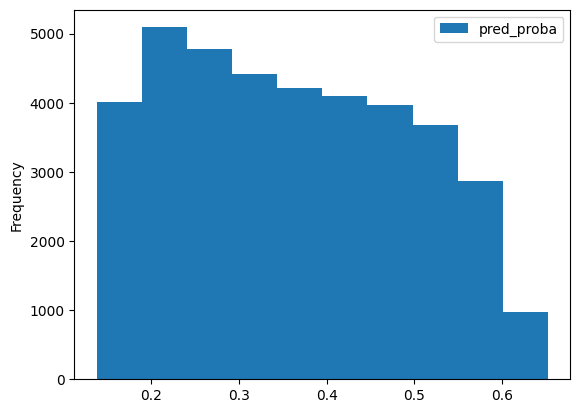

In [31]:
y_proba_default.plot.hist()

<Axes: ylabel='Frequency'>

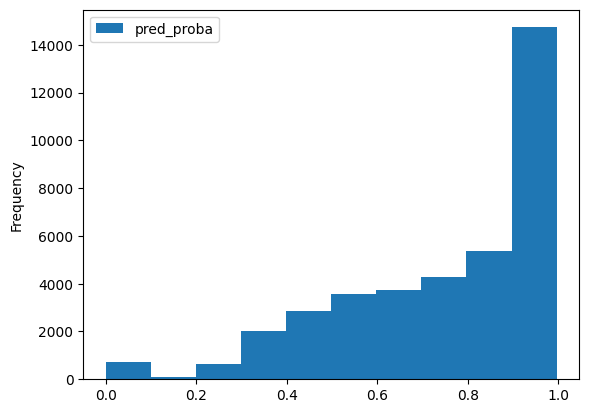

In [32]:
y_proba_refusal.plot.hist()

In [33]:
refusal_model.percentiles

{5: 0.3275484651327133,
 10: 0.4115106821060181,
 15: 0.47777122259140015,
 20: 0.53521808385849,
 25: 0.5865068435668945,
 30: 0.6385565042495728,
 35: 0.6883886277675628,
 40: 0.7359593868255616,
 45: 0.77903151512146,
 50: 0.8186862468719482,
 55: 0.8545660555362702,
 60: 0.8887248754501343,
 65: 0.9176592528820038,
 70: 0.9404829978942871,
 75: 0.9581927359104156,
 80: 0.9702341437339783,
 85: 0.979102087020874,
 90: 0.9857287883758545,
 95: 0.9902535080909729}

In [34]:
default_model.percentiles

{5: 0.15481257140636445,
 10: 0.16540981829166412,
 15: 0.17466070204973222,
 20: 0.1846488744020462,
 25: 0.19522149115800858,
 30: 0.20588216185569763,
 35: 0.2165662795305252,
 40: 0.22846890687942506,
 45: 0.24160739928483962,
 50: 0.2565116286277771,
 55: 0.27262136340141296,
 60: 0.2901276588439941,
 65: 0.3115715593099594,
 70: 0.33777904510498047,
 75: 0.365717276930809,
 80: 0.39953640699386594,
 85: 0.4340394586324691,
 90: 0.48093583583831784,
 95: 0.5380291283130643}

In [37]:
df['proba_refusal'] = y_proba_refusal
df['proba_default'] = y_proba_default

In [39]:
df['uw_decision'] = np.where(
    (df['proba_refusal'] >= refusal_model.percentiles[25]) | 
        (df['proba_default'] >= default_model.percentiles[90]),
    'refuse',
    'accept'
)

In [40]:
df['uw_decision'].value_counts()

uw_decision
refuse    28978
accept     9108
Name: count, dtype: int64

In [41]:
df['uw_decision'].value_counts(normalize=True)

uw_decision
refuse    0.760857
accept    0.239143
Name: proportion, dtype: float64